In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from matplotlib import pyplot as plt
import cv2
import gc
import tensorflow as tf
from tqdm import tqdm
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.applications import DenseNet121,DenseNet169,DenseNet201

In [3]:
x_train1 = np.load('x_train1.npy')
y_train1 = np.load('y_train1.npy')

In [4]:
from sklearn.model_selection import train_test_split
x_sptrain, x_spval, y_sptrain, y_spval = train_test_split(
    x_train1, y_train1, 
    random_state=42
)
print("train-validation splitted ")

train-validation splitted ...


In [5]:
del x_train1,y_train1
gc.collect()

0

In [6]:
from keras.preprocessing.image import ImageDataGenerator
def create_datagen():
    return ImageDataGenerator(
        horizontal_flip=True,   # randomly flip images
        vertical_flip=True,     # randomly flip images
        rotation_range=20 ,      # Degree range for random rotations
        zoom_range=0.1
    )

# Using original generator
data_generator = create_datagen().flow(x_sptrain, y_sptrain,batch_size=16,seed=20031976)
print("Image data augmentated ")

Image data augmentated ...


In [7]:
import tensorflow as tf
import keras.backend as K
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [8]:
gc.collect()

0

In [9]:
effnet = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(256,256,3)
)

In [10]:
model = Sequential()
model.add(effnet)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024,activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))

model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy',f1],
)

c:\Users\wankh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
gc.collect()

16309

In [12]:
# callback to keep track of kappa score during training
from keras.callbacks import Callback,ModelCheckpoint
from sklearn.metrics import cohen_kappa_score
import json
class KappaMetrics(Callback):
    i=0
    def on_train_begin(self, logs={}):
        self.val_kappas = []
        
    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"Epoch: {epoch+1} val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model. - "+str(KappaMetrics.i))
            model_json = self.model.to_json()
            with open("model_in_json"+str(KappaMetrics.i)+".json", "w") as json_file:
                json.dump(model_json, json_file)
            self.model.save_weights("model_weights"+str(KappaMetrics.i)+".h5")
            KappaMetrics.i+=1
        return
    
kappa_score = KappaMetrics()

In [13]:
history = model.fit_generator(
    data_generator,
    steps_per_epoch= 3362/16,
    epochs=8,
    validation_data=(x_spval, y_spval),
    callbacks=[kappa_score],
)    

C:\Users\wankh\AppData\Local\Temp\ipykernel_3392\1249103516.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/8


AttributeError: in user code:

    File "c:\Users\wankh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\wankh\AppData\Local\Temp\ipykernel_3392\2868458885.py", line 14, in f1  *
        f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)

    AttributeError: module 'tensorflow' has no attribute 'is_nan'


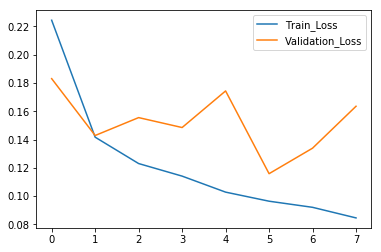

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train_Loss','Validation_Loss'])

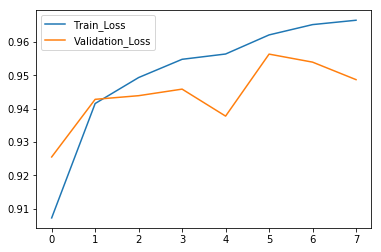

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train_Accuracy','Validation_Accuracy'])